In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from cardmaker import render_all_cards

render_all_cards()

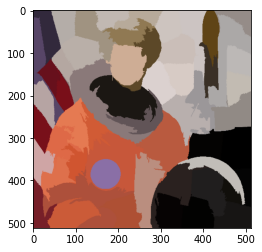

In [25]:
from skimage.segmentation import slic
from skimage import color
from skimage.data import astronaut
import matplotlib.pyplot as plt
img = astronaut()


plt.imshow(out1)


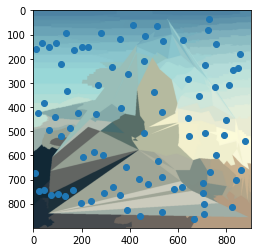

In [92]:
from PIL import Image, ImageFilter, ImageDraw
from skimage.segmentation import slic
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from scipy.spatial import Delaunay
import numpy as np

def _bbox2(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax

def _triangulation(img):
    #img = img.filter(ImageFilter.GaussianBlur(radius=5))
    #img = img.quantize(32)
    image_array = np.asarray(img)
    segments = slic(image_array, n_segments=100, compactness=1)
    segment_ids = [x+1 for x in range(np.array(segments).max())]
    # Centers method
    # segment_dict = {seg: (0, 0, 0) for seg in }
    # for ridx, row in enumerate(segments):
    #     for cidx, val in enumerate(row):
    #         segment_dict[val] = (segment_dict[val][0]+1, segment_dict[val][1]+ridx, segment_dict[val][2]+cidx)
    # centers = {seg: (segment_dict[seg][1]/segment_dict[seg][0], segment_dict[seg][2]/segment_dict[seg][0]) for seg in segment_dict.keys()}
    # points = list(centers.values())
    # BBOX Method
    # points = []
    # for seg in segments:
    #     mask = (np.array(segments) == seg).astype(int)
    #     rmin, rmax, cmin, cmax = _bbox2(mask)
    #     points.extend([(rmin, cmin), (rmin, cmax), (rmax, cmin), (rmax, cmax)])
    gray_image = rgb2gray(image_array)
    thresh = threshold_otsu(gray_image) 
    points = [tuple(x) for x in corner_peaks(corner_harris(gray_image > thresh), min_distance=5, threshold_rel=0.2)]
    
    tri = Delaunay(points)
    img = Image.fromarray(color.label2rgb(segments, image_array, kind='avg', bg_label=0))
    img2 = img.copy()
    draw = ImageDraw.Draw(img2)
    for a, b, c in tri.simplices:
        center = tuple(((np.array(points[a]).astype(float) + np.array(points[b]).astype(float) + np.array(points[c]).astype(float))/3.0).astype(int))
        draw.polygon([points[a], points[b], points[c]], fill=img.getpixel(center))
    
    return img2, centers

img = Image.open("./imagesearch/0073214c2e0024d284d43e482b8b5e729a6e623e1d323180f8f34207ea1ca70d/000001.jpg")
img, centers = _triangulation(img)
implot = plt.imshow(img)
plt.plot(*np.transpose(list(centers.values())), 'o')
plt.show()